# <center>Exploratory Data Analysis (EDA)</center>

In [2]:
pip install prince

## Imports

In [105]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings # For handling error messages.
# suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore")

## Load The Data
We load the two datasets from the previous step, *df_student* contains the cleaned original dataset and *df_student_numeric* containing all numeric features after encoding the categorical features.

In [6]:
df_student = pd.read_csv('./data/data_student_cleaned.csv')
df_student_numeric= pd.read_csv('./data/data_student_numeric.csv')

In [7]:
df_student.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,math
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,math
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,math
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,math
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,math


In [8]:
df_student_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   school_GP          1038 non-null   int64
 1   sex_F              1038 non-null   int64
 2   age                1038 non-null   int64
 3   address_U          1038 non-null   int64
 4   famsize_GT3        1038 non-null   int64
 5   Pstatus_A          1038 non-null   int64
 6   Medu               1038 non-null   int64
 7   Fedu               1038 non-null   int64
 8   traveltime         1038 non-null   int64
 9   studytime          1038 non-null   int64
 10  failures           1038 non-null   int64
 11  schoolsup          1038 non-null   int64
 12  famsup             1038 non-null   int64
 13  paid               1038 non-null   int64
 14  activities         1038 non-null   int64
 15  nursery            1038 non-null   int64
 16  higher             1038 non-null   int64
 17  internet      

# Explore the data

## School summary data

We add a *support* column to specify whether the student has received any support (family, school or paid). 

In [11]:
df_student['support'] = np.logical_or(np.logical_or(df_student_numeric['paid'].astype('bool'),df_student_numeric['schoolsup'].astype('bool')),df_student_numeric['famsup'].astype('bool')) 
df_student.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,goout,Dalc,Walc,health,absences,G1,G2,G3,course,support
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,6,5,6,6,math,True
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,4,5,5,6,math,True
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,10,7,8,10,math,True
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,2,15,14,15,math,True
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,4,6,10,10,math,True


In [12]:
school_summary = df_student.groupby(['school','course']).agg(
    number_student=pd.NamedAgg(column='school', aggfunc='size'), 
    percentage_Female=pd.NamedAgg(column='sex', aggfunc=lambda x: sum(x=='F')/len(x)),
    percentage_Male=pd.NamedAgg(column='sex', aggfunc=lambda x: sum(x=='M')/len(x)),
    #number_student_math=pd.NamedAgg(column='course', aggfunc=lambda x: sum(x=='math')),
    #number_student_portuguese=pd.NamedAgg(column='course', aggfunc=lambda x: sum(x=='portuguese')),
    avg_age=pd.NamedAgg(column='age', aggfunc="mean"),
    age_range=pd.NamedAgg(column='age', aggfunc=lambda x: [min(x),max(x)]),
    number_Rural=pd.NamedAgg(column='address', aggfunc=lambda x: sum(x=='R')),
    number_Urban=pd.NamedAgg(column='address', aggfunc=lambda x: sum(x=='U')),
    reason_most_common=pd.NamedAgg(column='reason', aggfunc=lambda x: x.mode()),
    sum_absences=pd.NamedAgg(column='absences', aggfunc=lambda x: sum(x)),
    percentage_failures=pd.NamedAgg(column='failures', aggfunc=lambda x: sum(x)/len(x)),
    #percentage_student_schoolsup=pd.NamedAgg(column='schoolsup', aggfunc=lambda x: sum(x=='yes')/len(x)),
    #percentage_student_famsup=pd.NamedAgg(column='famsup', aggfunc=lambda x: sum(x=='yes')/len(x)),
    #percentage_student_paidsup=pd.NamedAgg(column='paid', aggfunc=lambda x: sum(x=='yes')/len(x)),
    percentage_student_support=pd.NamedAgg(column='support', aggfunc=lambda x: sum(x==True)/len(x)),
    percentage_student_higher=pd.NamedAgg(column='higher', aggfunc=lambda x: sum(x=='yes')/len(x)),
    percentage_student_internet=pd.NamedAgg(column='internet', aggfunc=lambda x: sum(x=='yes')/len(x)),
    travelTime_most_common=pd.NamedAgg(column='traveltime', aggfunc=lambda x: x.mode()),
    freetime_most_common=pd.NamedAgg(column='freetime', aggfunc=lambda x: x.mode()),
    goout_most_common=pd.NamedAgg(column='goout', aggfunc=lambda x: x.mode()),
    studytime_most_common=pd.NamedAgg(column='studytime', aggfunc=lambda x: x.mode()),
    G1_range=pd.NamedAgg(column='G1', aggfunc=lambda x: [min(x),max(x)]),
    avg_G1=pd.NamedAgg(column='G1', aggfunc="mean"),
    G2_range=pd.NamedAgg(column='G2', aggfunc=lambda x: [min(x),max(x)]),
    avg_G2=pd.NamedAgg(column='G2', aggfunc="mean"),
    G3_range=pd.NamedAgg(column='G3', aggfunc=lambda x: [min(x),max(x)]),
    avg_G3=pd.NamedAgg(column='G3', aggfunc="mean")
).reset_index()
school_summary.set_index(['school','course'],inplace=True)
df_student.drop(columns=['support'])
school_summary.head().T



school                              GP                    MS           
course                            math portuguese       math portuguese
number_student                     344        422         46        226
percentage_Female             0.520349   0.559242   0.543478   0.646018
percentage_Male               0.479651   0.440758   0.456522   0.353982
avg_age                      16.502907  16.665877  18.021739  16.889381
age_range                     [15, 22]   [15, 22]   [17, 21]   [15, 20]
number_Rural                        61         78         25        119
number_Urban                       283        344         21        107
reason_most_common              course     course     course     course
sum_absences                      1819       1751        173        592
percentage_failures            0.31686   0.172986   0.456522   0.314159
percentage_student_support    0.776163   0.682464   0.521739    0.59292
percentage_student_higher     0.953488   0.924171   0.934783   0.836283
percentage_student_internet   0.848837   0.841232   0.695652   0.628319
travelTime_most_common               1          1          2          2
freetime_most_common                 3          3     [3, 4]          3
goout_most_common                    3          3          3          3
studytime_most_common                2          2          2          2
G1_range                       [3, 19]    [0, 18]    [6, 19]    [4, 19]
avg_G1                       10.950581  11.981043  10.673913  10.300885
G2_range                       [0, 19]    [6, 19]    [5, 18]    [0, 18]
avg_G2                       10.793605   12.14218  10.195652  10.495575
G3_range                       [0, 20]    [0, 19]    [0, 19]    [0, 19]
avg_G3                       10.505814   12.57346   9.847826  10.650442

We first want to visualize the distribution of student in the two schools regarding their location (urban or rural). The GP school has more students than the MS school. Students at the GP School come mainly from urban areas, while the MS School enrolls a balanced proportion of students from urban and rural areas.  

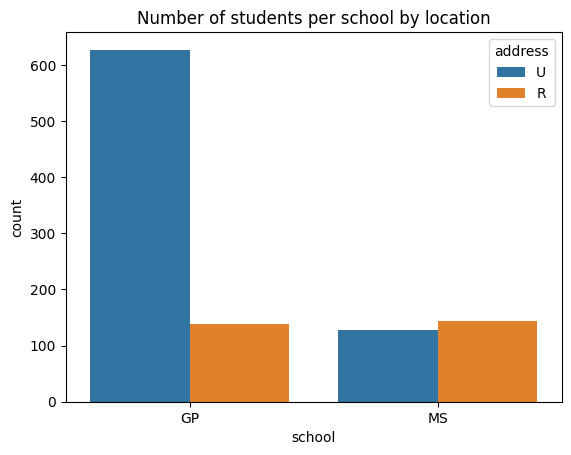

In [14]:
sns.countplot(x="school",data=df_student,hue="address") 
_ = plt.title("Number of students per school by location")

The distribution of students in the two schools regarding Math and Portuguese courses shows that most of the data relates to the Portuguese course at the two schools.

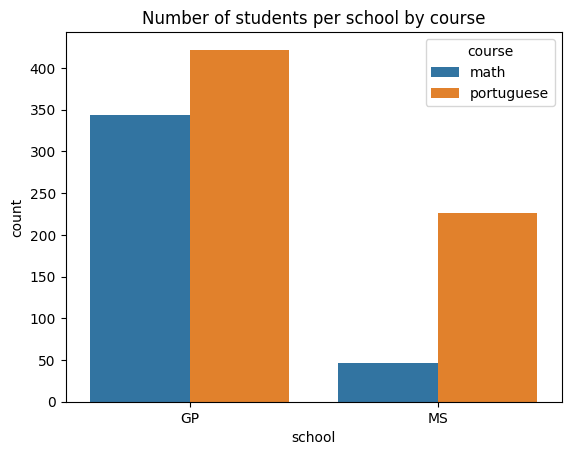

In [16]:
sns.countplot(x="school",data=df_student,hue="course") 
_ = plt.title("Number of students per school by course")

Students' choice of school was mainly based on the courses offered by the two schools. A good proportion of students also chose the GP school because of its proximity to their home and its reputation.

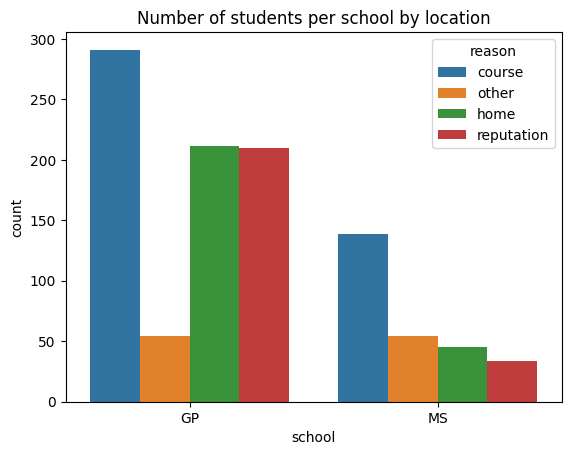

In [18]:
sns.countplot(x="school",data=df_student,hue="reason") 
_ = plt.title("Number of students per school by location")

We propose to explore student demographic information in the data. We first plot the distribution of student according to their gender. There are more female students than male students in the data.

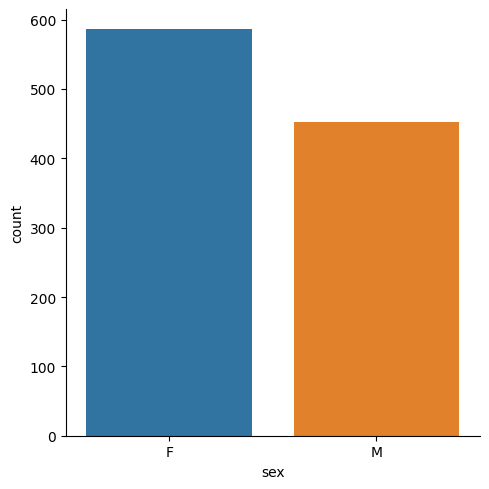

In [20]:
sns.catplot(x='sex', data=df_student, kind='count') 
plt.show()

Most students are aged between 15 and 18 years old.

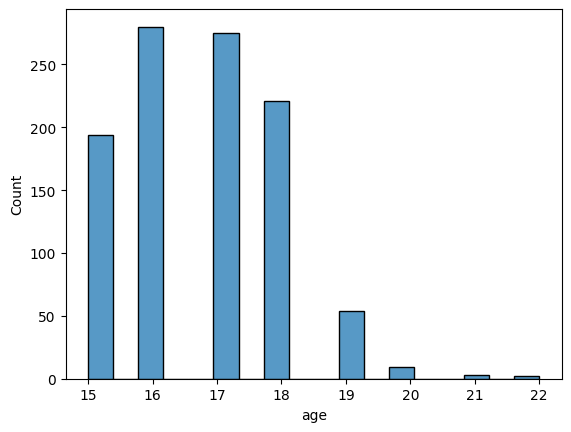

In [22]:
sns.histplot(x='age', data=df_student) 
plt.show()

There are fewer students from separated families in the data and most students are guarded by their mothers, regardless of whether their parents are separated or together.

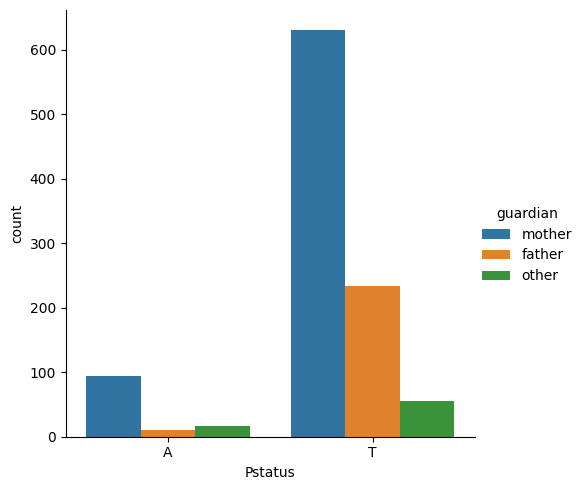

In [24]:
sns.catplot(x='Pstatus', hue='guardian', data=df_student, kind='count')
#sns.countplot(x="freetime",data=df_student,hue="school") 
plt.show()

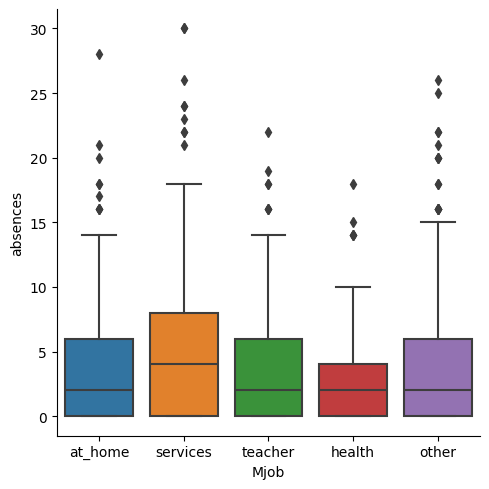

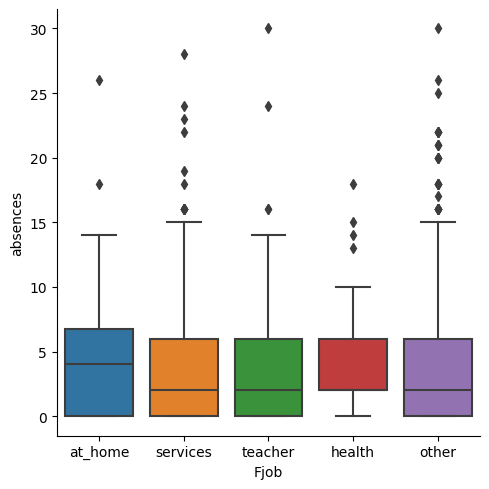

In [25]:
category_order = ["at_home", "services",  "teacher", "health","other"] 
sns.catplot(x='Mjob', y='absences', data=df_student,kind='box',order=category_order)
sns.catplot(x='Fjob', y='absences', data=df_student,kind='box',order=category_order)
plt.show()

The mother's job has a more effect on student absences than the father's. This is to be expected, since the mother is the main guardian.

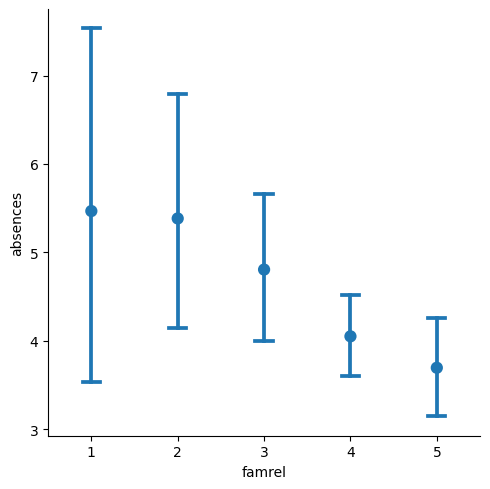

In [27]:
sns.catplot(x="famrel", y="absences", data=df_student, kind="point", capsize=0.2,join=False) 

Although the average number of absences is slightly lower among students with better family relationships, the wide confidence intervals indicate that we cannot be sure that there is a true association.

<Axes: xlabel='Dalc'>

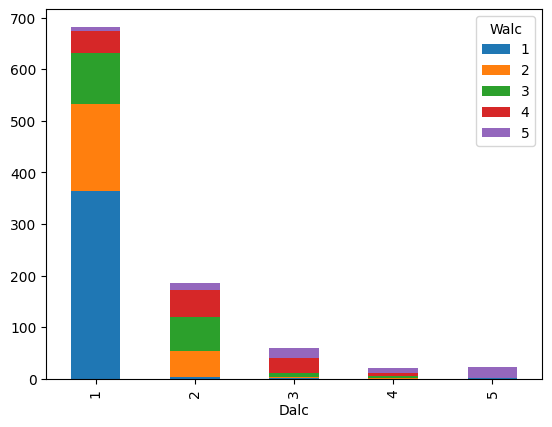

In [29]:
counts = df_student[df_student['age']<=18].groupby(['Dalc', 'Walc']).size().unstack()
counts.plot(kind='bar', stacked=True)

we notice alcohol consumption among minors in these two schools.

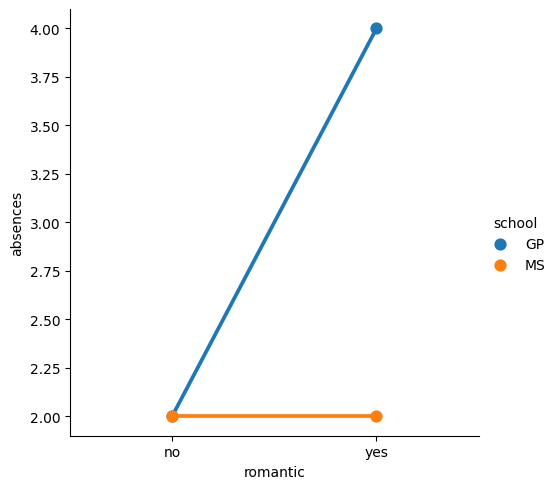

In [31]:
sns.catplot(x="romantic", y="absences", data=df_student, kind="point", hue="school", errorbar=None,estimator=np.median) 

Students in a romantic relationship have a higher median number of absences in GP school, but this association does not hold true in MS school. 

# Dependent vs Independent variables¶
We will explore the relationship between our target variable G3 and the other independent variables.
We start examining the impact of internet on student results.

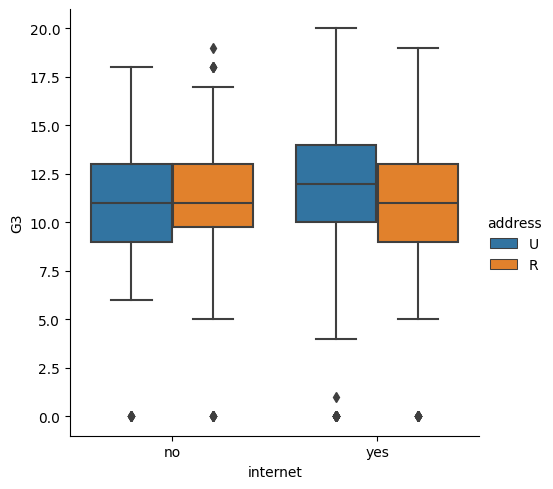

In [34]:
sns.catplot(data=df_student,x="internet",y="G3",kind="box",hue="address") 

Internet access brings no benefit to students from rural areas, their grades have not been affected by the availability of the internet and, in some cases, it has even worsened their school results, perhaps due to improper use. A slight improvement is observed in the results of students from urban areas.

Next, we plot the target variable G3 against the number of absences considering the different study time:
1. <2 hours
2. 2 to 5 hours
3. 5 to 10 hours
4. \>10 hours

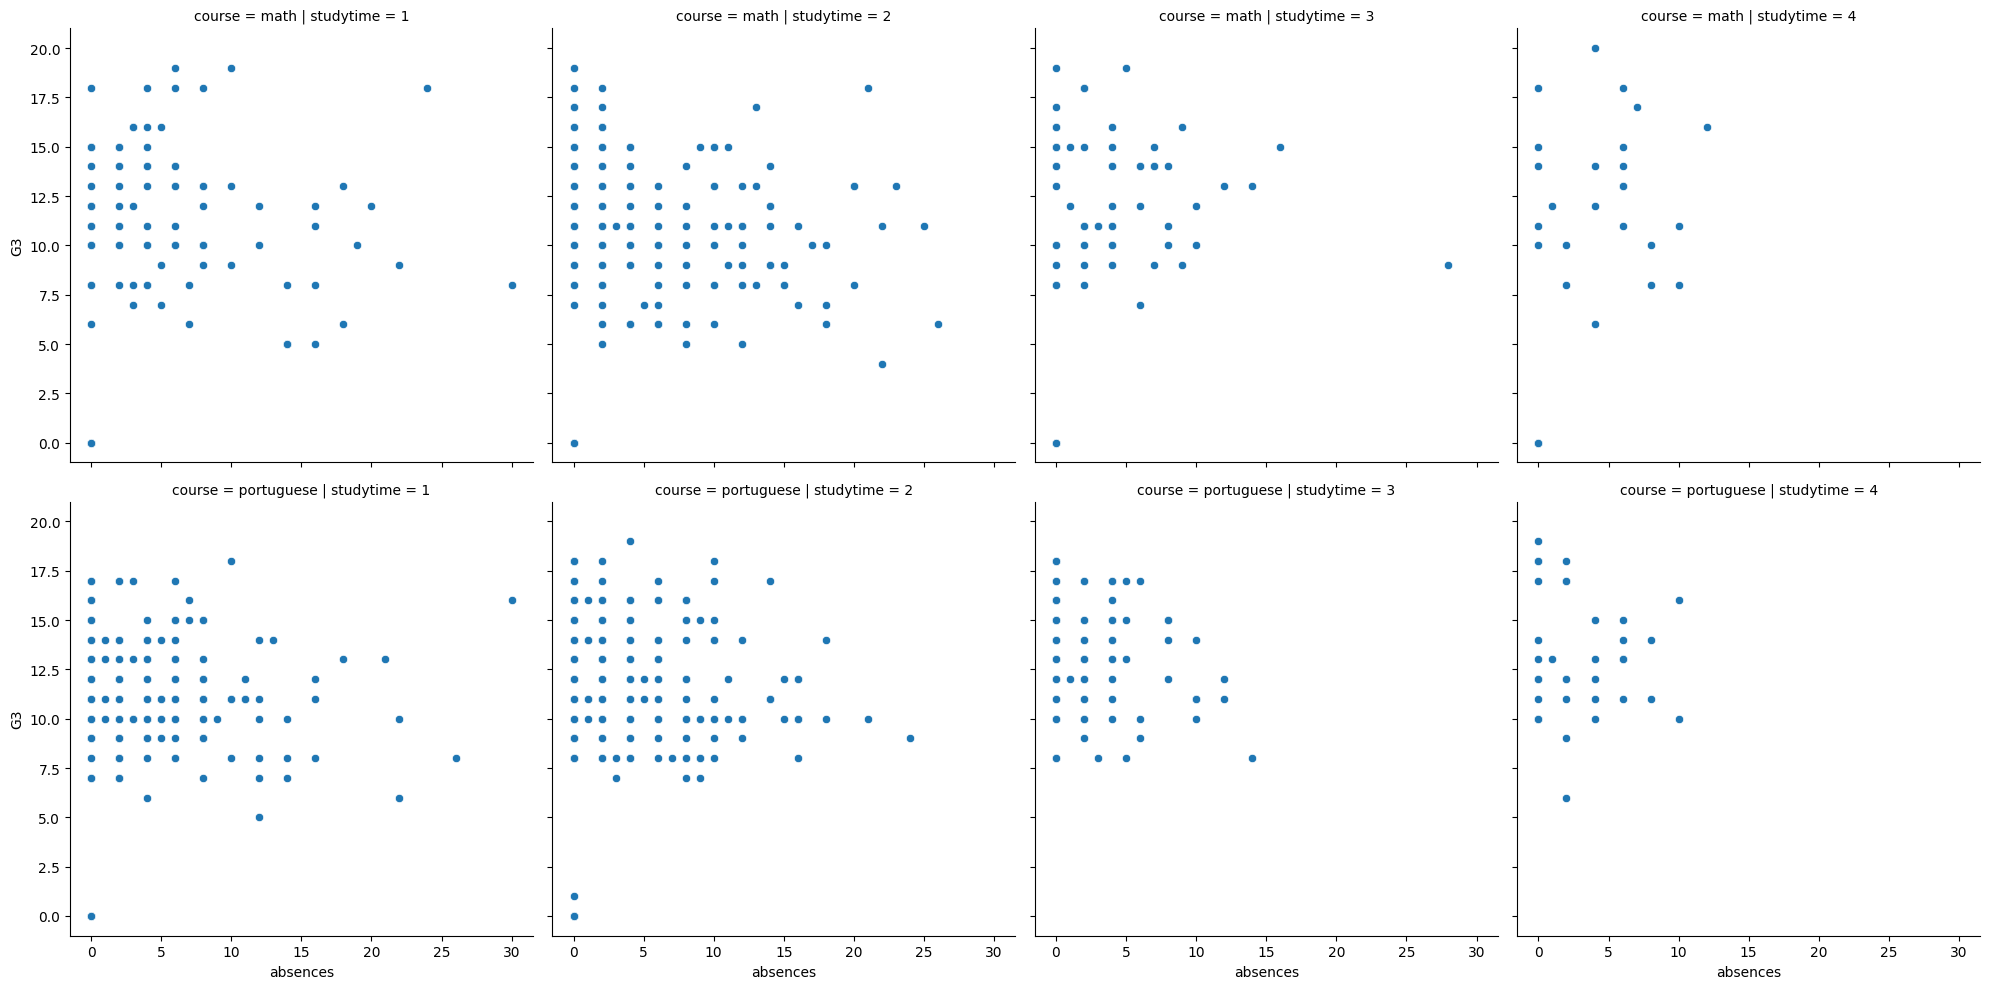

In [36]:
sns.relplot(x="absences", y="G3", data=df_student, kind="scatter", col="studytime",row="course") 
 

Students studying more time are less likely to skip classes and have better grades regardless of the course. 

We then plot the relationship between G1 and G3 regarding the family and school support a student can receive.

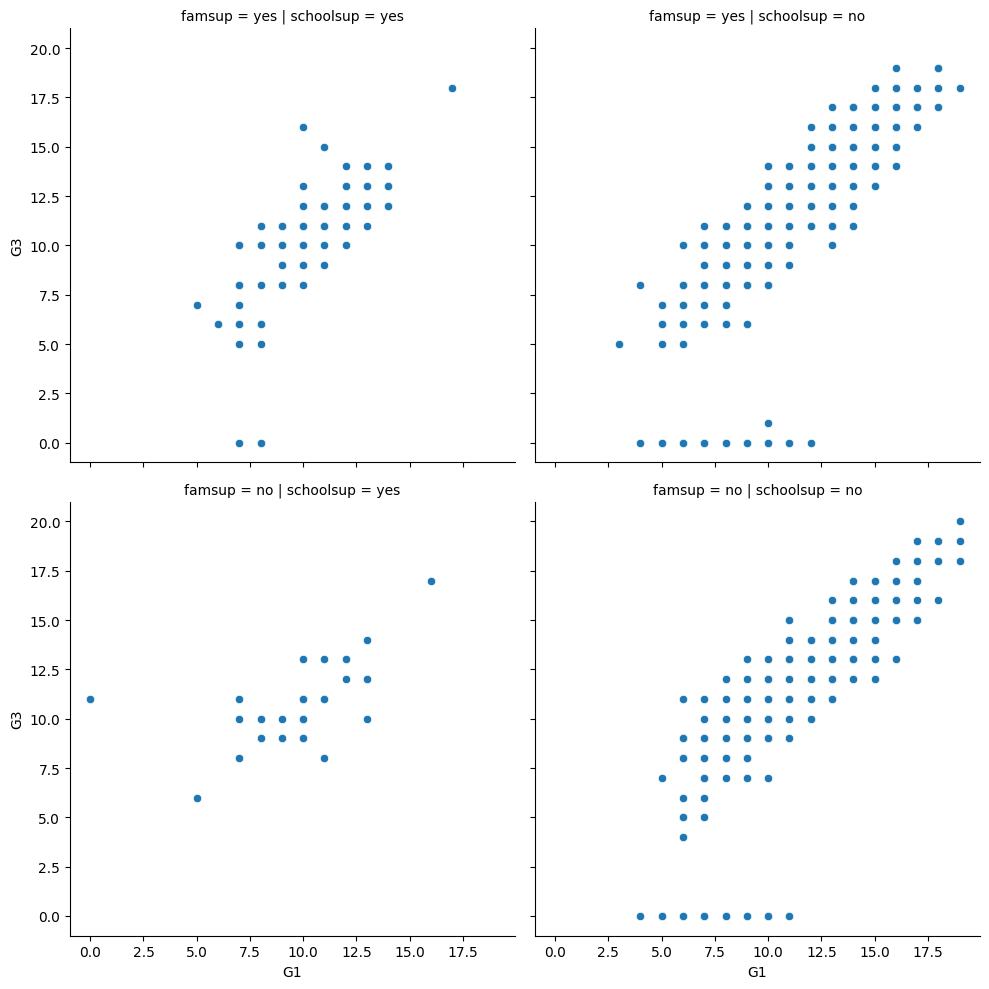

In [38]:
sns.relplot(x="G1", y="G3", data=df_student, kind="scatter",  col="schoolsup", col_order=["yes", "no"], row="famsup", row_order=["yes","no"])

There is a correlation between G1 and G3 regardless of the type of support received by the student.  

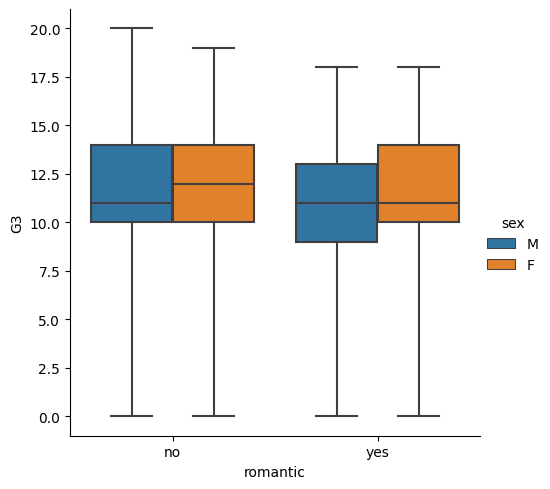

In [40]:
sns.catplot(x="romantic", y="G3", data=df_student,hue='sex',hue_order=['M','F'], kind="box", whis=[0, 100]) 

The median and maximum grades are higher among students who are not in a romantic relationship. Female students' grades are less affected by these relationships. 

We plot the relationship between G3 and all other features in the following. For the categorical features, bar plots are presented with each category's mean of G3 grades. 

In [42]:
def plots(df,columns,kind,course=None, ncol=None, figsize=(20,20)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.3, hspace=0.8)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        category_means = df.groupby([col,'course'])['G3'].mean().reset_index()
        if kind=="bar":
            sns.barplot(x=col, y='G3', data=category_means,hue="course",ax=ax)
            ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",mode='expand', ncol=2)
        elif kind=='strip':
            sns.stripplot(x=col, y='G3', data=df,ax=ax)
            ax.set(title="G3 vs "+ col + " in "+ course + " course")
        else:
            sns.scatterplot(x=col, y="G3", data=df_student,ax=ax)
        ax.set(xlabel=col, ylabel='G3')
        ax.tick_params(axis='x', labelrotation=45)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)




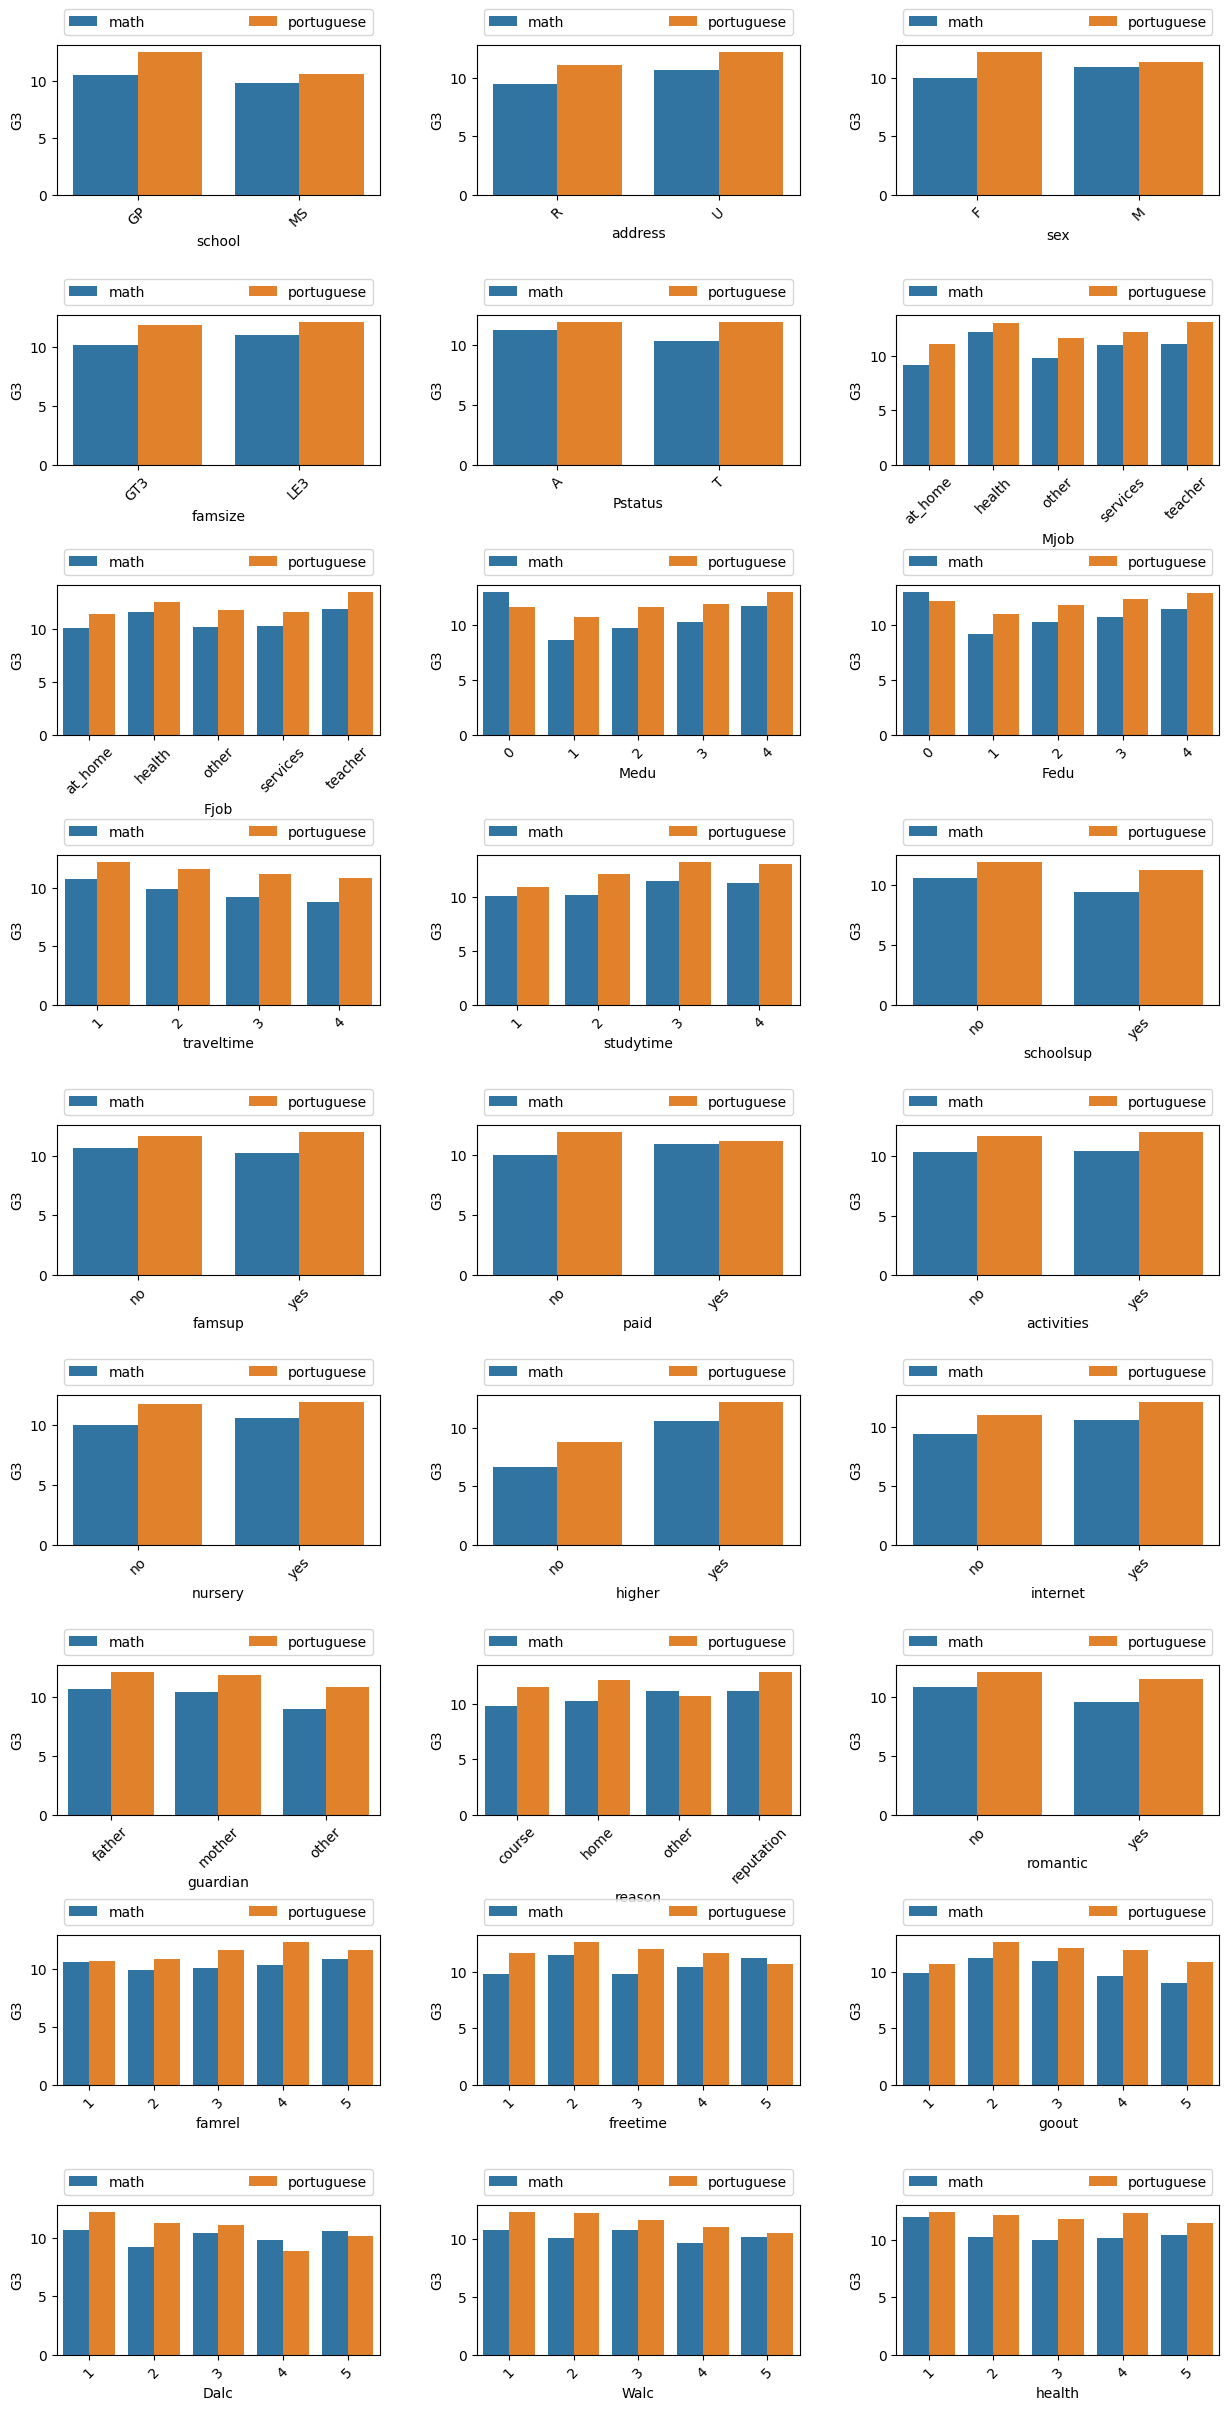

In [43]:
cat_features = ['school','address','sex','famsize','Pstatus','Mjob','Fjob','Medu', 'Fedu','traveltime', 'studytime', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet','guardian','reason',
       'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health'] 
plots(df_student,cat_features,kind="bar", ncol=3, figsize=(15, 30))


We next plot the G3 column against numeric features namely *age*, *failures* and *absences* for the two courses math and portuguese.

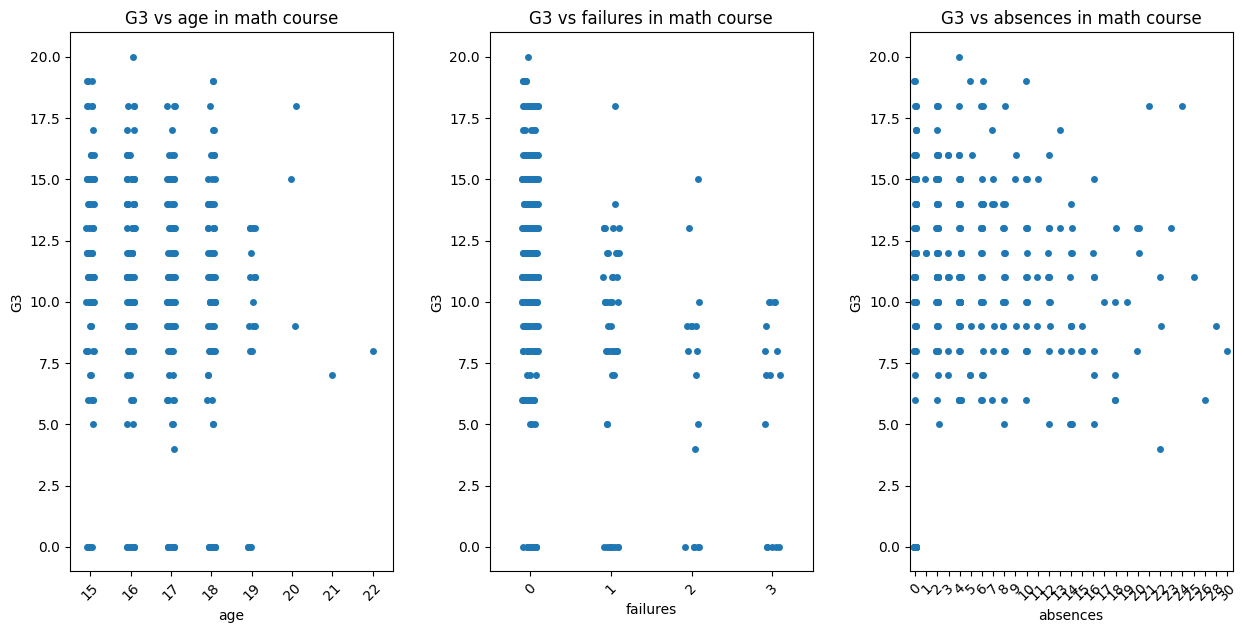

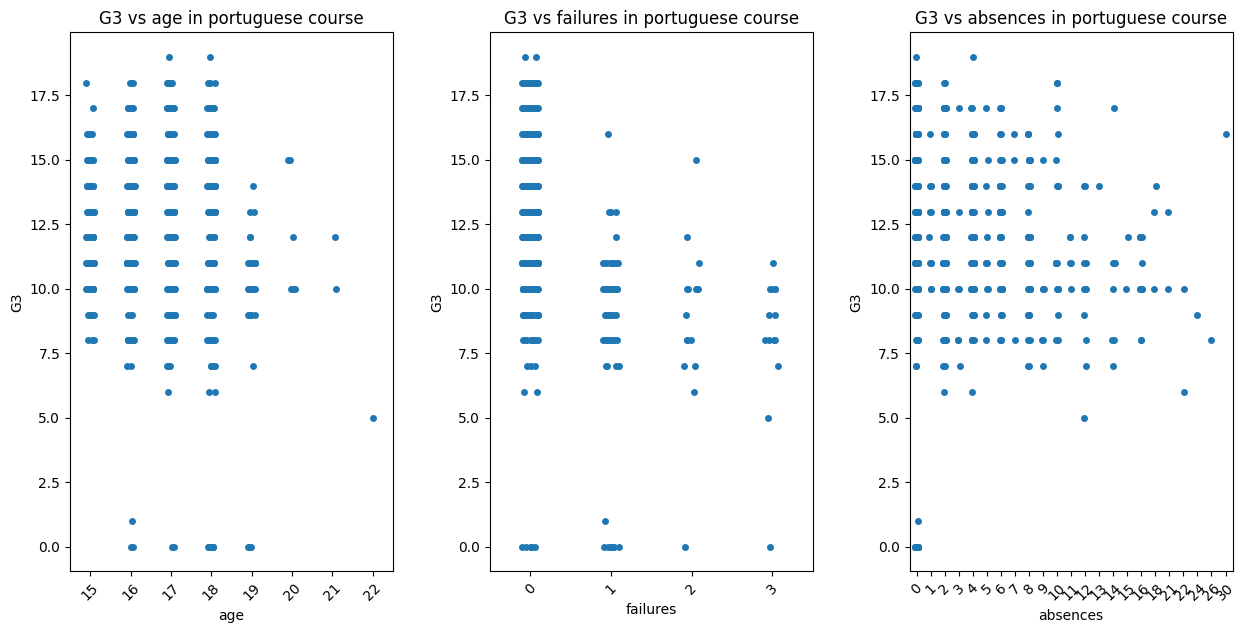

In [45]:
num_features = ["age","failures","absences"]
plots(df_student[df_student['course']=='math'],num_features,kind="strip",course='math', ncol=3, figsize=(15, 7))
plots(df_student[df_student['course']=='portuguese'],num_features,kind="strip",course='portuguese', ncol=3, figsize=(15, 7))

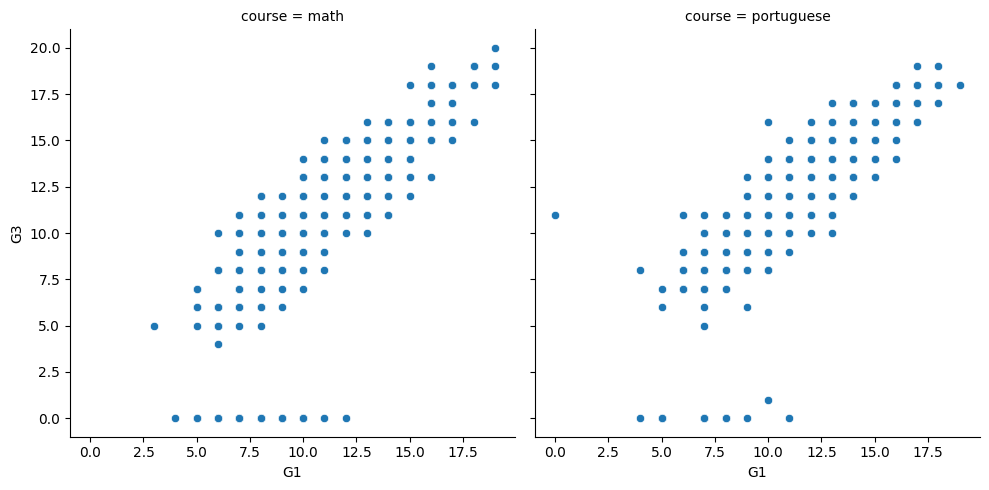

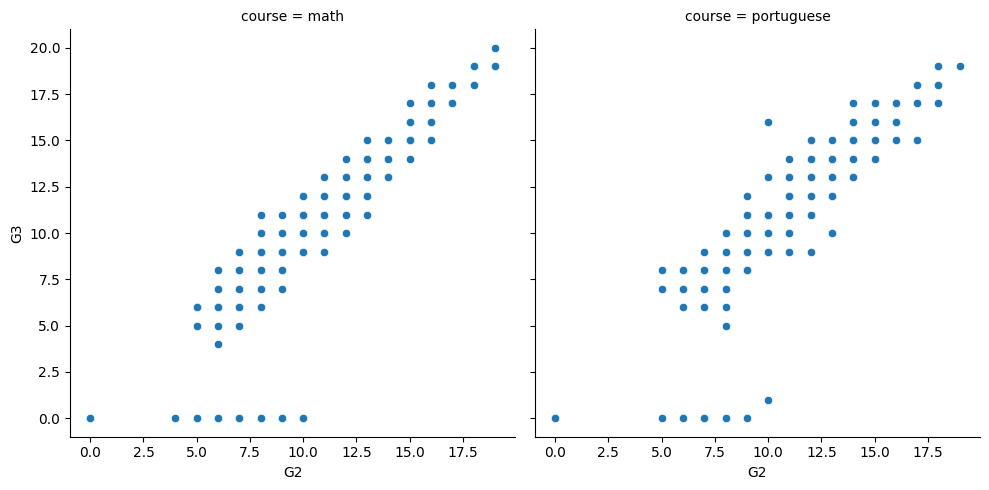

In [46]:
sns.relplot(x="G1", y="G3", data=df_student, kind="scatter", col="course")
sns.relplot(x="G2", y="G3", data=df_student, kind="scatter", col="course")

There is a strong correlation between G1 and G2 and G3.

# Features relatioship

Let's study the relationship between categorical variables. Below, we detail the study of the association between weekday and weekend alcohol consumption.

In [50]:
contingency_table = pd.crosstab(df_student['Dalc'], df_student['Walc'])
print(contingency_table)

Walc    1    2    3   4   5
Dalc                       
1     388  178  106  43   9
2       4   52   70  55  12
3       1    2   17  31  18
4       1    2    5   8  10
5       1    1    0   0  24


We specify our null hypothesis and alternative hypothesis as follows:

- Null Hypothesis: There is no association between the two categorical variables.
- Alternative Hypothesis: There is an association between the two categorical variables.

and then we apply a chi2 test. 

In [52]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
alpha = 0.05  # significance level
print(f"P-Value: {p}")

if p < alpha:
    print("Reject the null hypothesis: There is a significant association between the two categorical variables.")
else:
    print("Fail to reject the null hypothesis: No significant association between the two categorical variables.")

P-Value: 2.359528106379298e-142
Reject the null hypothesis: There is a significant association between the two categorical variables.


We then propose to apply the chi-test to all categorical variables.

In [99]:
cat_features = ['school','address','sex','famsize','Pstatus','Mjob','Fjob','Medu', 'Fedu','traveltime', 'studytime', 'schoolsup',
       'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet','guardian','reason',
       'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health','course'] 
pvalues_table=np.empty([len(cat_features),len(cat_features)])

for i,col1 in enumerate(cat_features):
    for j,col2 in enumerate(cat_features):
        contingency_tablij = pd.crosstab(df_student[col1], df_student[col2])
        chi2, p, dof, expected = chi2_contingency(contingency_tablij)
        pvalues_table[i,j] = p 
        
       

In [100]:
df_pvalues = pd.DataFrame(pvalues_table,index=cat_features,columns=cat_features)
df_pvalues = df_pvalues.astype(float)

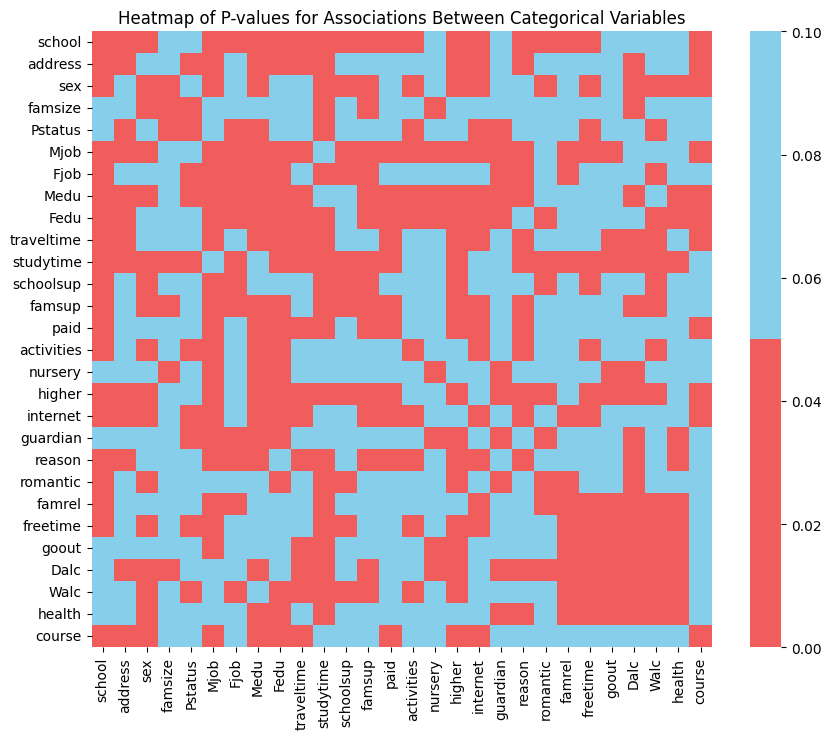

In [101]:
colors = ['#F15C5C', 'skyblue']  # Red for low p-values, white for middle range, blue for high p-values
n_bins = [2]
cmap_name = 'p_value_cmap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins[0])

plt.figure(figsize=(10, 8))
sns.heatmap(df_pvalues, cmap=custom_cmap, vmin=0, vmax=0.1, center=0.05)
plt.title('Heatmap of P-values for Associations Between Categorical Variables')
plt.show()

There is a significant association between many categorical variables. 

To assess whether the means of the target variable G3 differ significantly across different categories of categorical variables, we propose to perform ANOVA (Analysis of Variance).

In [1721]:
significance = []
for col in cat_features:
    groups = [df_student['G3'][df[col] == group] for group in df_student[col].unique()]

    # Perform one-way ANOVA
    f_statistic, p_value = stats.f_oneway(*groups)
    # Interpretation
    if p_value < 0.05:
        #print(f"There is a significant difference between the group means for {col}: P-value: {p_value}")
        significance.append(True)
    else:
        #print(f"There is no significant difference between the group means  for {col}: P-value: {p_value}")
        significance.append(False)

significance_df = pd.DataFrame(significance,index=cat_features,columns=['G3'])
significance_df

,G3
school,True
address,True
sex,False
famsize,False
Pstatus,False
Mjob,True
Fjob,True
Medu,True
Fedu,True
traveltime,True


The means of the target variable G3 are not significantly different across the levels of the categorical variables *sex, famsize, Pstatus, famsup, paid, activities, nursery*, and *famrel*.

We compute the correlation between numeric features.

In [1724]:
numeric_features = ['age', 'failures', 'absences','G1','G2','G3']
df_student[numeric_features].corr()


,age,failures,absences,G1,G2,G3
age,1.000000,0.280293,0.152248,-0.123630,-0.117866,-0.123643
failures,0.280293,1.000000,0.122943,-0.374899,-0.377478,-0.383471
absences,0.152248,0.122943,1.000000,-0.101863,-0.093560,-0.035980
G1,-0.123630,-0.374899,-0.101863,1.000000,0.858861,0.808945
G2,-0.117866,-0.377478,-0.093560,0.858861,1.000000,0.910662
G3,-0.123643,-0.383471,-0.035980,0.808945,0.910662,1.000000


There is a strong positive correlation between the three grades exceeding 0.8. 

# Factor Analysis of Mixed Data (FAMD)

We propose to perform a dimension reduction technique to reduce the number of dimensions (features) in our dataset while retaining as much of the original variability as possible. This allows us to simplify the data and improve efficiency, in fact, lower dimensionality often leads to faster processing and can improve the performance of subsequent modeling techniques. Since our dataset contains categorical and numeric data, we are applying Factor Analysis of Mixed Data (FAMD). 

In [111]:
import prince

Cumulative percentage of variance: [ 5.16804869  9.29347232 12.5819961  15.61938138 18.59500177 21.25332465
 23.77377259 26.18838434 28.54793928 30.82025921 33.05954553 35.23301786
 37.38415421 39.44411264 41.44235991 43.41760895 45.33468751 47.2075576
 49.05058367 50.83653077 52.57349264 54.28220168 55.94996939 57.59356256
 59.21558624 60.82321514 62.42305253 64.00743381 65.50944359 66.96548612
 68.38873769 69.79044574 71.18682313 72.5120481  73.83014873 75.11748152
 76.36378074 77.60568931 78.82518098 79.97619536]


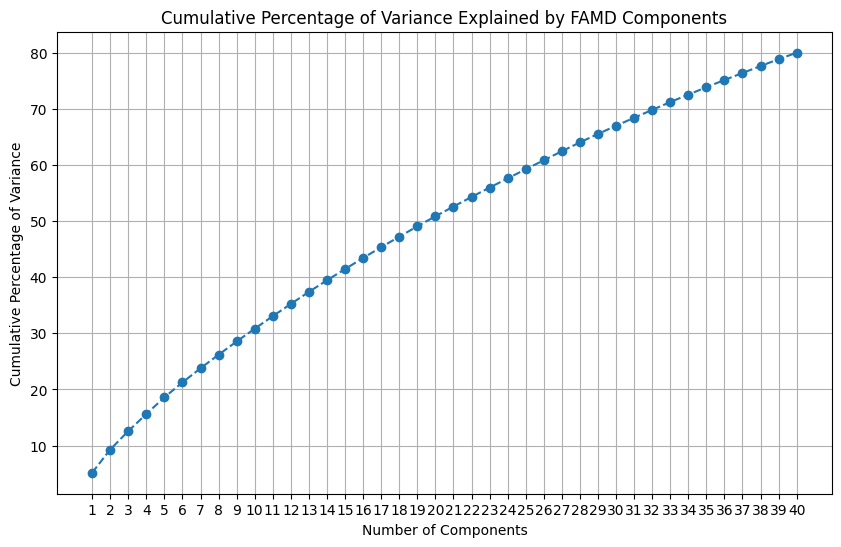

In [113]:
#df_student_scale = scale(df_student_numeric)
#student_pca = PCA().fit(df_student_scale)
df_student_numeric[['G1','G2','age','absences','failures']] =  df_student_numeric[['G1','G2','age','absences','failures']].astype(float)
scaler = StandardScaler()
df_student_numeric[['G1','G2','age','absences','failures']] = scaler.fit_transform(df_student_numeric[['G1','G2','age','absences','failures']])
final_df= df_student_numeric.drop(columns=['G3'])

famd = prince.FAMD(n_components=40)
famd.fit(final_df)

# Transform data
transformed_data = famd.transform(final_df)

# Get explained variance ratio
cumulative_variance = famd.cumulative_percentage_of_variance_

print("Cumulative percentage of variance:", cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Percentage of Variance')
plt.title('Cumulative Percentage of Variance Explained by FAMD Components')
plt.xticks(range(1, len(cumulative_variance) + 1))
plt.grid(True)
plt.show()

The cumulative percentage of the explained variance allows understanding how much variance is explained as we accumulate components. 
The cumulative variance curve above does not allow us to choose the number of components as we can not see where the plot starts to stabilize, it seems like additional components contribute considerably to explaining the variance.


# Hypothesis testing

We propose to solve the following problem: Is there a difference in the mean grade G3 for student with any support (family, school or paid) against those having no support.

We display here boxplots of the G3 column, separated by support. 

<Axes: title={'center': 'G3'}, xlabel='support'>

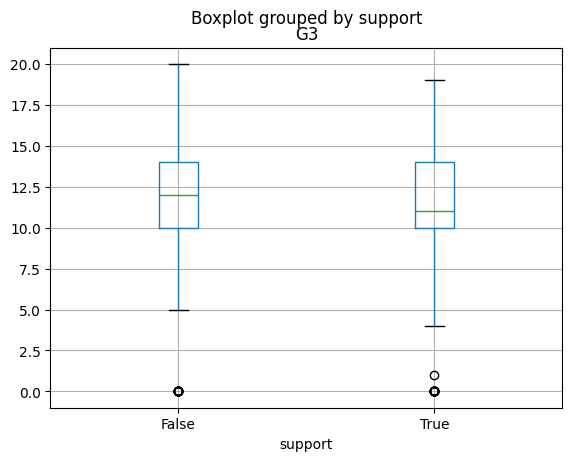

In [1733]:
df_student.boxplot(column='G3',by='support')

### Hypothesis formulation

Our hypothesis is:

- H0: the observed difference in the mean G3 of supported students and non-supported students is due to chance (and thus not due to the support).
- H1: the observed difference in the average G3 of of supported students and non-supported students is not due to chance (and is actually due to support)


We fix a significance level of 0.05.

In [117]:
support = df_student[df_student['support']==True]['G3']
non_support = df_student[df_student['support']==False]['G3']

#### Test of normality

In [119]:
support_normal = stats.normaltest(support)
print(support_normal)

NormaltestResult(statistic=104.57060489110799, pvalue=1.9623734672497563e-23)


In [121]:
non_support_normal = stats.normaltest(non_support)
print(non_support_normal)

NormaltestResult(statistic=61.679764970862024, pvalue=4.040259071337099e-14)


Since the p-values are too small for both tests, if we pick a significance level of 0.05, we conclude that the data are not normally distributed. Let's check with the distribution of the data visually using a histogram.

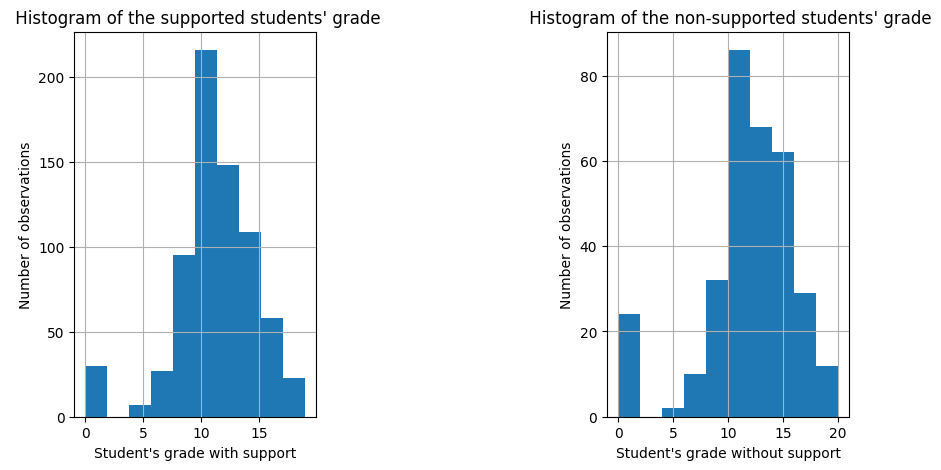

In [143]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
fig.subplots_adjust(wspace=1.2)
support.hist(ax=axs[0])
axs[0].set_xlabel("Student's grade with support")
axs[0].set_ylabel("Number of observations")
axs[0].set_title(" Histogram of the supported students' grade")
non_support.hist(ax=axs[1])
axs[1].set_xlabel("Student's grade without support")
axs[1].set_ylabel("Number of observations")
axs[1].set_title(" Histogram of the non-supported students' grade")
plt.show()

#### Permutation test
We are using a non-parametric test here.

In [1742]:
difference = np.empty(10000)
df=df_student 
for i in range(10000):
    df['Permutation'] = np.random.permutation(df['G3'])
    difference[i] = df[df['support']==True]['Permutation'].mean() - df[df['support']==False]['Permutation'].mean()

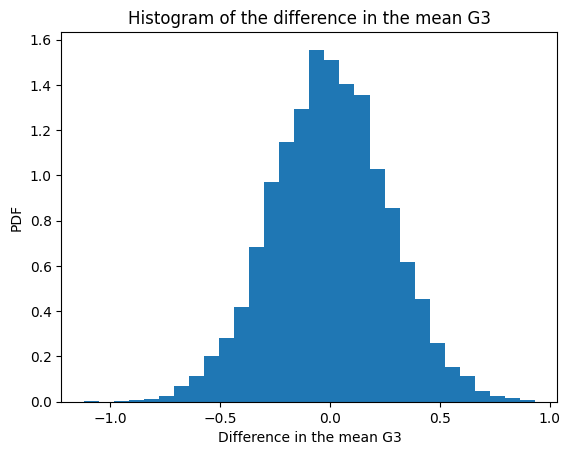

In [1743]:
histo = plt.hist(difference,bins=30,density=True)
_ = plt.xlabel("Difference in the mean G3")
_ = plt.ylabel("PDF")
_ = plt.title("Histogram of the difference in the mean G3")

In [1744]:
obs_difference = df[df['support']==True]['G3'].mean() - df[df['support']==False]['G3'].mean()
obs_difference = np.abs(obs_difference) 
print(obs_difference)

0.029819829539325937


In [1745]:
p_value = np.sum(difference >= obs_difference) / len(difference)
p_value

0.4518

The p value is greater than the significance level of 0.05, so we fail to reject the null hypothesis and we conclude that support does not impact on G3. We have seen above that the means of the target variable G3 are not significantly different across the levels of the categorical variables representing family support and paid support but it is for school support. We can verify this with a permutation test.

In [1747]:
difference = np.empty(10000)
df=df_student 
for i in range(10000):
    df['Permutation'] = np.random.permutation(df['G3'])
    difference[i] = df[df['schoolsup']=='yes']['Permutation'].mean() - df[df['schoolsup']=='no']['Permutation'].mean()

obs_difference = df[df['schoolsup']=='yes']['G3'].mean() - df[df['schoolsup']=='no']['G3'].mean()
obs_difference = np.abs(obs_difference) 
p_value = np.sum(difference >= obs_difference) / len(difference)
p_value

0.0038

A p value less than 0.05 allows us to reject the null hypothesis and thus the school support has an impact on G3.